# CS933 Image & Video Analysis coursework 2023-2024, Part 2
> ID: 5556162, Name: Tien Yu Lin

## Module imports

In [1]:
import cv2

from lib.public import db, show_images_in_row

## Read origin images

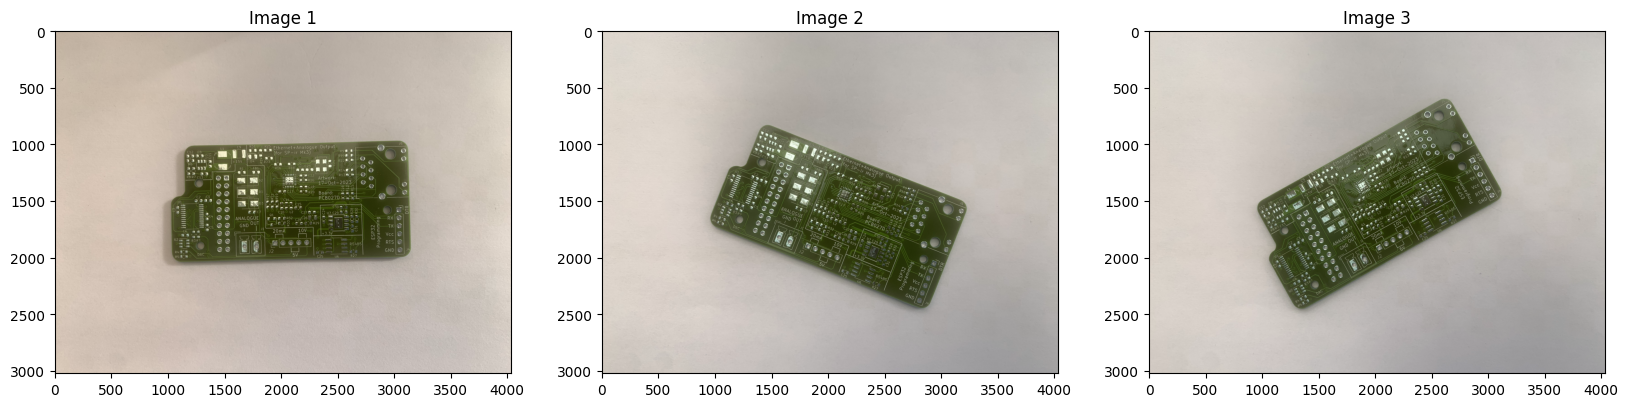

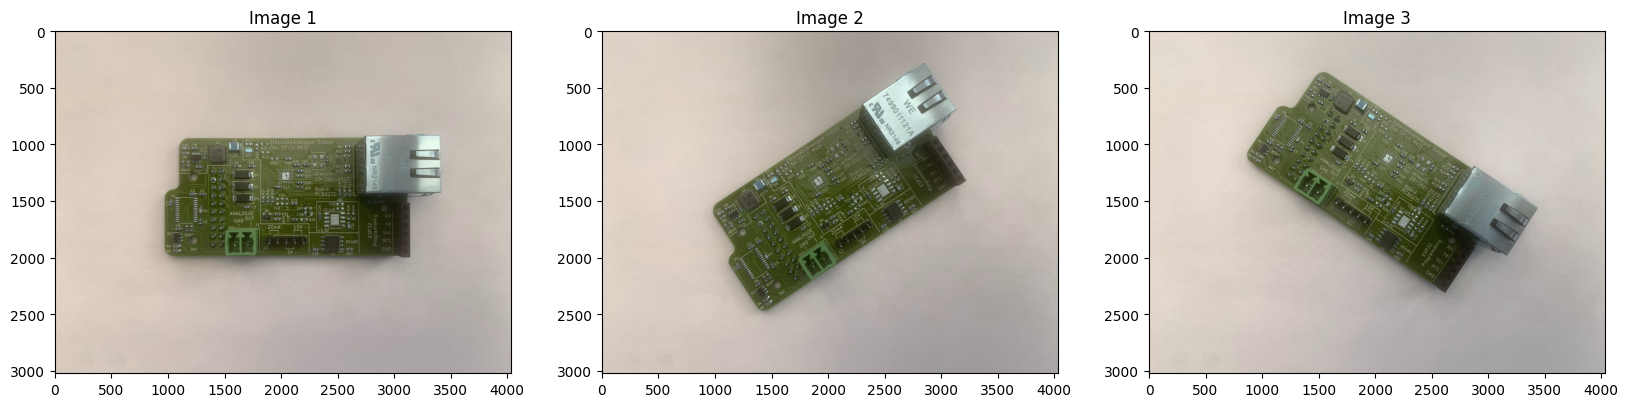

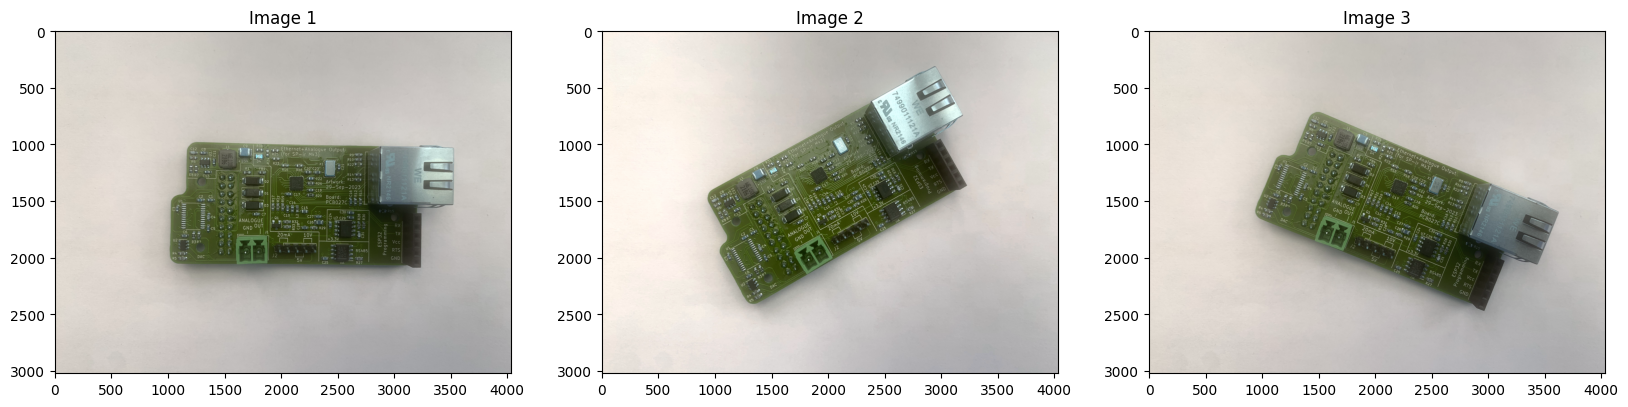

In [2]:
board1s = tuple(
    cv2.imread(f'{db.boards_dir}/BOARD1-{i + 1}.jpg')
    for i in range(3)
)

board2s = tuple(
    cv2.imread(f'{db.boards_dir}/BOARD2-{i + 1}.jpg')
    for i in range(3)
)

board3s = tuple(
    cv2.imread(f'{db.boards_dir}/BOARD3-{i + 1}.jpg')
    for i in range(3)
)

show_images_in_row(board1s)
show_images_in_row(board2s)
show_images_in_row(board3s)